# On Deep Learning-Based Channel Decoding

If you want to cite this notebook, please use the following bibtext entry:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

Running this example requires Keras installed with the Theano backend. For GPU support nvidia-docker is required. A Dockerfile is provided to employ this setup quickly.

Our simulation setup was inspired by material from http://radioml.org.


In [1]:
import numpy as np
# import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Parameters

In [2]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

nb_epoch = 2**12            # number of learning epochs
code = 'polar'              # type of code ('random' or 'polar')
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

p = 9 / 10
num_train = int(2**k * p)
num_test = int(2**k - num_train)

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

# Define NN model

In [3]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
#     return K.sum(K.not_equal(y_true, K.round(y_pred)))
#     return tf.reduce_mean(K.cast(K.equal(y_true, K.round(y_pred)),dtype = 'float32'))
    return K.sum(K.cast(K.not_equal(y_true, K.round(y_pred)),dtype = 'int32'))

In [4]:
# Define modulator
modulator_layers = [Lambda(modulateBPSK, 
                          input_shape=(N,), output_shape=return_output_shape, name="modulator")]
modulator = compose_model(modulator_layers)
modulator.compile(optimizer=optimizer, loss=loss)

# Define noise
noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                       input_shape=(N,), output_shape=return_output_shape, name="noise")]
noise = compose_model(noise_layers)
noise.compile(optimizer=optimizer, loss=loss)

# Define LLR
llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                     input_shape=(N,), output_shape=return_output_shape, name="LLR")]
llr = compose_model(llr_layers)
llr.compile(optimizer=optimizer, loss=loss)

# Define decoder 
decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
for i in range(1,len(design)):
    decoder_layers.append(Dense(design[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))
decoder = compose_model(decoder_layers)
decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

# Define model
if LLR:
    model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
else:
    model_layers = modulator_layers + noise_layers + decoder_layers
model = compose_model(model_layers)
model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

# Data Generation

In [5]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [6]:
# Create all possible information words
d_all = np.zeros((2**k,k),dtype=bool)
d = np.zeros((num_train,k),dtype=bool)   # use for train
d_for_test = np.zeros((num_test,k),dtype=bool) 

for i in range(1,2**k):
    d_all[i]= inc_bool(d_all[i-1])
    
# if p != 0,mean that only some data use for train,and the other use for test
if p != 0:
    print("not all data use for train")
    random_sequence = np.zeros(2**k,dtype=int)
    for i in range(0,2**k):
        random_sequence[i] = i
    random.shuffle(random_sequence)
    for i in range(0,num_train):
        d[i] = d_all[random_sequence[i]]
    for i in range(num_train,num_train+num_test):
        d_for_test[i - num_train] = d_all[random_sequence[i]]
else:
    print("all data train")
#     d = np.zeros(((2**k,k),dtype=bool)
    d = d_all

# Create sets of all possible codewords (codebook)
if code == 'polar':   
    
    A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
#     x = np.zeros((2**k, N),dtype=bool)
#     u = np.zeros((2**k, N),dtype=bool)
    x = np.zeros((len(d), N),dtype=bool)
    u = np.zeros((len(d), N),dtype=bool)
    u[:,A] = d

    for i in range(0,len(d)):
        x[i] = polar_transform_iter(u[i])

elif code == 'random':
    
    np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    x = np.random.randint(0,2,size=(len(d),N), dtype=bool)

not all data use for train


# Train Neural Network

In [7]:
model.summary()
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=1, shuffle=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 modulator (Lambda)          (None, 16)                0         
                                                                 
 noise (Lambda)              (None, 16)                0         
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 12,776
Trainable params: 12,776
Non-trai

1/1 [==============================] - 0s 8ms/step - loss: 0.1518 - ber: 0.2538
Epoch 162/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1581 - ber: 0.2625
Epoch 163/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1554 - ber: 0.2533
Epoch 164/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1489 - ber: 0.2418
Epoch 165/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1552 - ber: 0.2533
Epoch 166/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1543 - ber: 0.2543
Epoch 167/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1544 - ber: 0.2576
Epoch 168/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1533 - ber: 0.2462
Epoch 169/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1556 - ber: 0.2543
Epoch 170/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1513 - ber: 0.2543
Epoch 171/4096
1/1 [==============================] - 0s 6ms/step

1/1 [==============================] - 0s 6ms/step - loss: 0.1405 - ber: 0.2288
Epoch 334/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1411 - ber: 0.2277
Epoch 335/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1388 - ber: 0.2255
Epoch 336/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1415 - ber: 0.2364
Epoch 337/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1380 - ber: 0.2299
Epoch 338/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1439 - ber: 0.2364
Epoch 339/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1376 - ber: 0.2168
Epoch 340/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1435 - ber: 0.2359
Epoch 341/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1382 - ber: 0.2424
Epoch 342/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1451 - ber: 0.2299
Epoch 343/4096
1/1 [==============================] - 0s 8ms/step

1/1 [==============================] - 0s 6ms/step - loss: 0.1412 - ber: 0.2293
Epoch 506/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1418 - ber: 0.2228
Epoch 507/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1405 - ber: 0.2228
Epoch 508/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1400 - ber: 0.2261
Epoch 509/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1428 - ber: 0.2304
Epoch 510/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1322 - ber: 0.2136
Epoch 511/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1415 - ber: 0.2342
Epoch 512/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.1458 - ber: 0.2337
Epoch 513/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1411 - ber: 0.2277
Epoch 514/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1378 - ber: 0.2201
Epoch 515/4096
1/1 [==============================] - 0s 5ms/ste

1/1 [==============================] - 0s 8ms/step - loss: 0.1359 - ber: 0.2168
Epoch 678/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1381 - ber: 0.2136
Epoch 679/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1361 - ber: 0.2136
Epoch 680/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1301 - ber: 0.2016
Epoch 681/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1311 - ber: 0.2043
Epoch 682/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1262 - ber: 0.1951
Epoch 683/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1353 - ber: 0.2223
Epoch 684/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1282 - ber: 0.2027
Epoch 685/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1347 - ber: 0.2125
Epoch 686/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1353 - ber: 0.2201
Epoch 687/4096
1/1 [==============================] - 0s 7ms/step

1/1 [==============================] - 0s 6ms/step - loss: 0.1211 - ber: 0.1826
Epoch 850/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1326 - ber: 0.2141
Epoch 851/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1299 - ber: 0.1989
Epoch 852/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1266 - ber: 0.2011
Epoch 853/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1323 - ber: 0.2033
Epoch 854/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1334 - ber: 0.2087
Epoch 855/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1260 - ber: 0.1880
Epoch 856/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1215 - ber: 0.1875
Epoch 857/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1229 - ber: 0.1837
Epoch 858/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1201 - ber: 0.1793
Epoch 859/4096
1/1 [==============================] - 0s 10ms/ste

1/1 [==============================] - 0s 5ms/step - loss: 0.1342 - ber: 0.2038
Epoch 1022/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1206 - ber: 0.1859
Epoch 1023/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1176 - ber: 0.1652
Epoch 1024/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1300 - ber: 0.2120
Epoch 1025/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1352 - ber: 0.2065
Epoch 1026/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1285 - ber: 0.1973
Epoch 1027/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1273 - ber: 0.2016
Epoch 1028/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1377 - ber: 0.2212
Epoch 1029/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1242 - ber: 0.1815
Epoch 1030/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1283 - ber: 0.1946
Epoch 1031/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.1160 - ber: 0.1696
Epoch 1192/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1184 - ber: 0.1799
Epoch 1193/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1221 - ber: 0.1815
Epoch 1194/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1230 - ber: 0.1783
Epoch 1195/4096
1/1 [==============================] - 0s 12ms/step - loss: 0.1265 - ber: 0.1837
Epoch 1196/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1268 - ber: 0.1897
Epoch 1197/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1184 - ber: 0.1728
Epoch 1198/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1256 - ber: 0.1864
Epoch 1199/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1190 - ber: 0.1755
Epoch 1200/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1029 - ber: 0.1478
Epoch 1201/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 5ms/step - loss: 0.1126 - ber: 0.1630
Epoch 1362/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1164 - ber: 0.1734
Epoch 1363/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1187 - ber: 0.1755
Epoch 1364/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1183 - ber: 0.1804
Epoch 1365/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1124 - ber: 0.1582
Epoch 1366/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1208 - ber: 0.1821
Epoch 1367/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1124 - ber: 0.1630
Epoch 1368/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1169 - ber: 0.1745
Epoch 1369/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1102 - ber: 0.1690
Epoch 1370/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1177 - ber: 0.1723
Epoch 1371/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.1085 - ber: 0.1630
Epoch 1532/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1195 - ber: 0.1799
Epoch 1533/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1164 - ber: 0.1663
Epoch 1534/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1140 - ber: 0.1674
Epoch 1535/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1074 - ber: 0.1592
Epoch 1536/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1117 - ber: 0.1696
Epoch 1537/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1116 - ber: 0.1668
Epoch 1538/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1025 - ber: 0.1489
Epoch 1539/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1134 - ber: 0.1571
Epoch 1540/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1095 - ber: 0.1516
Epoch 1541/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 7ms/step - loss: 0.1075 - ber: 0.1500
Epoch 1702/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0977 - ber: 0.1386
Epoch 1703/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1188 - ber: 0.1712
Epoch 1704/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0990 - ber: 0.1440
Epoch 1705/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0917 - ber: 0.1255
Epoch 1706/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1088 - ber: 0.1652
Epoch 1707/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1091 - ber: 0.1647
Epoch 1708/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1112 - ber: 0.1603
Epoch 1709/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1007 - ber: 0.1402
Epoch 1710/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1044 - ber: 0.1500
Epoch 1711/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0885 - ber: 0.1201
Epoch 1872/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0958 - ber: 0.1304
Epoch 1873/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0920 - ber: 0.1310
Epoch 1874/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1082 - ber: 0.1543
Epoch 1875/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.1050 - ber: 0.1478
Epoch 1876/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1053 - ber: 0.1603
Epoch 1877/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1092 - ber: 0.1549
Epoch 1878/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0989 - ber: 0.1451
Epoch 1879/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1181 - ber: 0.1701
Epoch 1880/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1175 - ber: 0.1630
Epoch 1881/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 8ms/step - loss: 0.1080 - ber: 0.1560
Epoch 2042/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0938 - ber: 0.1337
Epoch 2043/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1019 - ber: 0.1473
Epoch 2044/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1058 - ber: 0.1473
Epoch 2045/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0922 - ber: 0.1228
Epoch 2046/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1013 - ber: 0.1451
Epoch 2047/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0932 - ber: 0.1234
Epoch 2048/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0910 - ber: 0.1332
Epoch 2049/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0932 - ber: 0.1250
Epoch 2050/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1041 - ber: 0.1451
Epoch 2051/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.1102 - ber: 0.1565
Epoch 2212/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0977 - ber: 0.1391
Epoch 2213/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1003 - ber: 0.1391
Epoch 2214/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0944 - ber: 0.1353
Epoch 2215/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0988 - ber: 0.1375
Epoch 2216/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0897 - ber: 0.1288
Epoch 2217/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1121 - ber: 0.1614
Epoch 2218/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1034 - ber: 0.1516
Epoch 2219/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1006 - ber: 0.1484
Epoch 2220/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1086 - ber: 0.1533
Epoch 2221/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0943 - ber: 0.1342
Epoch 2382/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0906 - ber: 0.1272
Epoch 2383/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0959 - ber: 0.1386
Epoch 2384/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1019 - ber: 0.1473
Epoch 2385/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0824 - ber: 0.1152
Epoch 2386/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1006 - ber: 0.1440
Epoch 2387/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0961 - ber: 0.1402
Epoch 2388/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.1039 - ber: 0.1435
Epoch 2389/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0946 - ber: 0.1337
Epoch 2390/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0913 - ber: 0.1266
Epoch 2391/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 6ms/step - loss: 0.0898 - ber: 0.1332
Epoch 2552/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0938 - ber: 0.1380
Epoch 2553/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0855 - ber: 0.1255
Epoch 2554/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0908 - ber: 0.1299
Epoch 2555/4096
1/1 [==============================] - 0s 11ms/step - loss: 0.1075 - ber: 0.1511
Epoch 2556/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0949 - ber: 0.1315
Epoch 2557/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0944 - ber: 0.1380
Epoch 2558/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0920 - ber: 0.1283
Epoch 2559/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0915 - ber: 0.1332
Epoch 2560/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0987 - ber: 0.1424
Epoch 2561/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 5ms/step - loss: 0.0961 - ber: 0.1386
Epoch 2722/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0930 - ber: 0.1310
Epoch 2723/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0953 - ber: 0.1321
Epoch 2724/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.1121 - ber: 0.1571
Epoch 2725/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0981 - ber: 0.1435
Epoch 2726/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0825 - ber: 0.1174
Epoch 2727/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0821 - ber: 0.1082
Epoch 2728/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1062 - ber: 0.1440
Epoch 2729/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1018 - ber: 0.1446
Epoch 2730/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0879 - ber: 0.1207
Epoch 2731/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0966 - ber: 0.1408
Epoch 2892/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0946 - ber: 0.1375
Epoch 2893/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0963 - ber: 0.1413
Epoch 2894/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0952 - ber: 0.1402
Epoch 2895/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0796 - ber: 0.1136
Epoch 2896/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0900 - ber: 0.1310
Epoch 2897/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0909 - ber: 0.1370
Epoch 2898/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0839 - ber: 0.1185
Epoch 2899/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0778 - ber: 0.1065
Epoch 2900/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.1011 - ber: 0.1478
Epoch 2901/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.0783 - ber: 0.1065
Epoch 3062/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0873 - ber: 0.1239
Epoch 3063/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0876 - ber: 0.1261
Epoch 3064/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0967 - ber: 0.1424
Epoch 3065/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0971 - ber: 0.1380
Epoch 3066/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0869 - ber: 0.1174
Epoch 3067/4096
1/1 [==============================] - 0s 10ms/step - loss: 0.0980 - ber: 0.1408
Epoch 3068/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0953 - ber: 0.1359
Epoch 3069/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0881 - ber: 0.1283
Epoch 3070/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0940 - ber: 0.1342
Epoch 3071/4096
1/1 [==============================] - 

1/1 [==============================] - 0s 7ms/step - loss: 0.0814 - ber: 0.1239
Epoch 3232/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0851 - ber: 0.1234
Epoch 3233/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0795 - ber: 0.1092
Epoch 3234/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0967 - ber: 0.1310
Epoch 3235/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0803 - ber: 0.1141
Epoch 3236/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0936 - ber: 0.1288
Epoch 3237/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0866 - ber: 0.1245
Epoch 3238/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0814 - ber: 0.1141
Epoch 3239/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0847 - ber: 0.1212
Epoch 3240/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0800 - ber: 0.1163
Epoch 3241/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0797 - ber: 0.1130
Epoch 3402/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0788 - ber: 0.1076
Epoch 3403/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0995 - ber: 0.1495
Epoch 3404/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0926 - ber: 0.1397
Epoch 3405/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0891 - ber: 0.1342
Epoch 3406/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0774 - ber: 0.0973
Epoch 3407/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.1034 - ber: 0.1386
Epoch 3408/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0965 - ber: 0.1391
Epoch 3409/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0965 - ber: 0.1304
Epoch 3410/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0754 - ber: 0.1060
Epoch 3411/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0869 - ber: 0.1239
Epoch 3572/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0947 - ber: 0.1250
Epoch 3573/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0944 - ber: 0.1261
Epoch 3574/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0816 - ber: 0.1092
Epoch 3575/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0766 - ber: 0.1016
Epoch 3576/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1034 - ber: 0.1462
Epoch 3577/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.1059 - ber: 0.1543
Epoch 3578/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0989 - ber: 0.1386
Epoch 3579/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0935 - ber: 0.1288
Epoch 3580/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0907 - ber: 0.1272
Epoch 3581/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0965 - ber: 0.1353
Epoch 3742/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0822 - ber: 0.1212
Epoch 3743/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0909 - ber: 0.1353
Epoch 3744/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0910 - ber: 0.1304
Epoch 3745/4096
1/1 [==============================] - 0s 9ms/step - loss: 0.0899 - ber: 0.1261
Epoch 3746/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0824 - ber: 0.1141
Epoch 3747/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0779 - ber: 0.1076
Epoch 3748/4096
1/1 [==============================] - 0s 8ms/step - loss: 0.0814 - ber: 0.1141
Epoch 3749/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0747 - ber: 0.1016
Epoch 3750/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0840 - ber: 0.1120
Epoch 3751/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.0775 - ber: 0.1043
Epoch 3912/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0876 - ber: 0.1272
Epoch 3913/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0840 - ber: 0.1179
Epoch 3914/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0888 - ber: 0.1212
Epoch 3915/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0863 - ber: 0.1234
Epoch 3916/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0831 - ber: 0.1114
Epoch 3917/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0745 - ber: 0.1103
Epoch 3918/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0928 - ber: 0.1255
Epoch 3919/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0950 - ber: 0.1402
Epoch 3920/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0972 - ber: 0.1375
Epoch 3921/4096
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.0881 - ber: 0.1245
Epoch 4082/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0782 - ber: 0.1087
Epoch 4083/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0883 - ber: 0.1255
Epoch 4084/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.1005 - ber: 0.1342
Epoch 4085/4096
1/1 [==============================] - 0s 5ms/step - loss: 0.0874 - ber: 0.1255
Epoch 4086/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0765 - ber: 0.1022
Epoch 4087/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0938 - ber: 0.1380
Epoch 4088/4096
1/1 [==============================] - 0s 6ms/step - loss: 0.0782 - ber: 0.1082
Epoch 4089/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0825 - ber: 0.1190
Epoch 4090/4096
1/1 [==============================] - 0s 7ms/step - loss: 0.0979 - ber: 0.1435
Epoch 4091/4096
1/1 [==============================] - 0

# Test NN

In [8]:
test_batch = 1000  
# num_words = 100000      # multiple of test_batch
num_words = 1000

# multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

In [21]:
SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

# result of training data test
nb_errors = np.zeros(len(sigmas),dtype=int)
nb_bits = np.zeros(len(sigmas),dtype=int)

# result of not training data test
nb_errors_2 = np.zeros(len(sigmas),dtype=int)
nb_bits_2 = np.zeros(len(sigmas),dtype=int)


for iiii in range(2):
    for i in range(0,len(sigmas)):

        for ii in range(0,np.round(num_words/test_batch).astype(int)):

            # Source
            np.random.seed(0)
            d_test = np.random.randint(0,2,size=(test_batch,k)) 

            if iiii == 0:
                for j in range(len(d_test)):
                    d_test[j] = d[np.random.randint(0,num_train)]
            elif p != 0:
                for j in range(len(d_test)):
                    d_test[j] = d_for_test[np.random.randint(0,num_test)]

            # Encoder
            if code == 'polar':
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,A] = d_test

                for iii in range(0,test_batch):
                    x_test[iii] = polar_transform_iter(u_test[iii])

            elif code == 'random':
                x_test = np.zeros((test_batch, N),dtype=bool)
                for iii in range(0,test_batch):
                    x_test[iii] = x[bin2int(d_test[iii])]

            # Modulator (BPSK)
            s_test = -2*x_test + 1

            # Channel (AWGN)
            y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

            if LLR:
                y_test = 2*y_test/(sigmas[i]**2)

            if iiii == 0:
                # Decoder
                nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=1)[1]
                nb_bits[i] += d_test.size
            elif p != 0:
                # Decoder
                nb_errors_2[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=1)[1]
                nb_bits_2[i] += d_test.size

1/1 [==============================] - 0s 21ms/step - loss: 0.0408 - errors: 375.0000


# Load MAP

In [19]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

# Plot Bit-Error-Rate

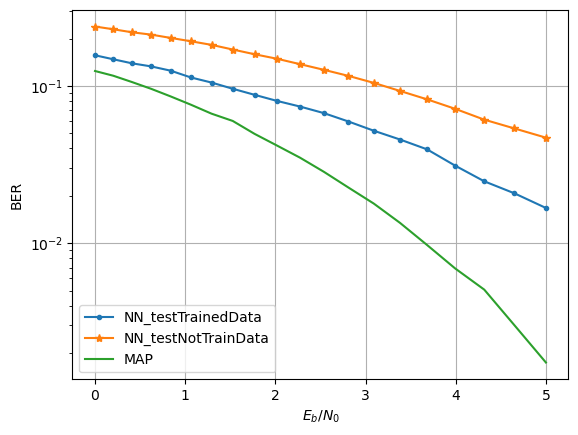

In [27]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits, '.-')
legend.append('NN_testTrainedData') 

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors_2/nb_bits_2, '-*')
legend.append('NN_testNotTrainData') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()